<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/main/AD_LTEM_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
# please make a copy before you make changes to this script

# will become public once we get the DOE approval
# !git clone https://github.com/danielzt12/AD_LTEM

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import signal as tfs
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys, time
from scipy.fftpack import *
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
from scipy import ndimage
from google.colab import output
import tifffile as tif
import gdown

# will be available once we get the approval
# sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla T4


In [3]:
# truth for amplitude and phase

# will be available once we get the approval
# true_amplitude =  tif.imread('AD_LTEM/design_amp.tiff')
# true_phase = tif.imread('AD_LTEM/design_tphi.tiff')

!gdown "http://drive.google.com/uc?id=1H8wKBG_owtsM8pxwPq_O5a38omplenXk"
!gdown "http://drive.google.com/uc?id=12cyeYc_GNvfQ94IqyScxjtB08DZCwPGY"
true_amplitude =  tif.imread('design_amp.tiff')
true_phase = tif.imread('design_tphi.tiff')

true_phase -= true_phase.mean()

!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"
from microscopes_fwd import Microscope

Downloading...
From: http://drive.google.com/uc?id=1H8wKBG_owtsM8pxwPq_O5a38omplenXk
To: /content/design_amp.tiff
100% 1.05M/1.05M [00:00<00:00, 16.7MB/s]
Downloading...
From: http://drive.google.com/uc?id=12cyeYc_GNvfQ94IqyScxjtB08DZCwPGY
To: /content/design_tphi.tiff
100% 1.05M/1.05M [00:00<00:00, 16.6MB/s]
Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 17.0MB/s]


In [4]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 10

defocus = np.linspace(-1.6e6,1.6e6,65)

!gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
A0 = np.load("amplitude4TIE_noise0.npy")

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise of the data set: {0:.1f}%".format((A_samples-A0).std()*200))

Downloading...
From: http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R
To: /content/amplitude4TIE_noise0.npy
136MB [00:01, 124MB/s]
Downloading...
From: http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk
To: /content/amplitude4TIE_noise10.npy
136MB [00:02, 60.1MB/s]
estimated noise of the data set: 10.3%


Text(0.5, 1.0, '1600000.0 nm')

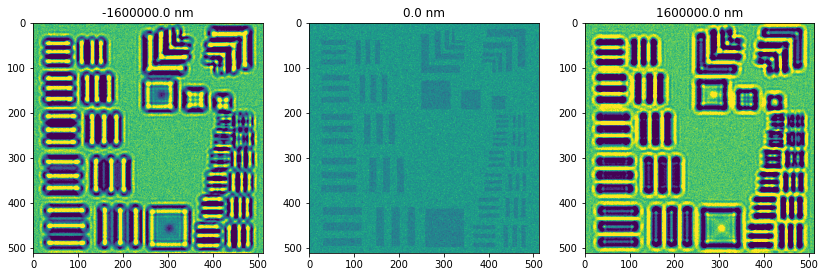

In [5]:
f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[32], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[1].set_title("{0} nm".format(defocus[32]))
ax[2].imshow(A_samples[64], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[2].set_title("{0} nm".format(defocus[64]))

# AD Phase Retrieval

In [ ]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 15

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")


Downloading...
From: http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l
To: /content/amplitude4TIE_noise15.npy
136MB [00:01, 89.3MB/s]


In [ ]:
# generate microscopic transfer function

!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

from microscopes_fwd import Microscope

defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex128)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)


Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 9.53MB/s]


In [ ]:
selection = [0,29,35,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]

chosen defocus (mm):  [-1.6  -0.15  0.15  1.6 ]


In [ ]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*TF)

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2) + lamb*tf.image.total_variation(tf.expand_dims(guess_phase,axis=-1))
  # lamb = 0 -> no TV regularization

  gerr = losses
  return losses


In [ ]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    if i>10:
      if np.abs(errs[-1]-errs[-2]) < tol or errs[-1]>errs[-2]:
        break

  return result_phase, np.array(errs), np.array(accs), i

In [ ]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
#guess_amplitude = tf.constant(A_samples[32], dtype='float32') # used for noise free data
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

In [ ]:
tot_errs = []
tot_accs = []

lr = 1
lamb = 0e-8 # no TV regularization
max_iter = 10000
t1=time.time()
result=optimize(1e-9,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

total elapsed time 209.7 s for 1674 iterations: 
final err 0.004537486471235752
final acc 0.966 
max acc 0.966 at iteration #1674: 


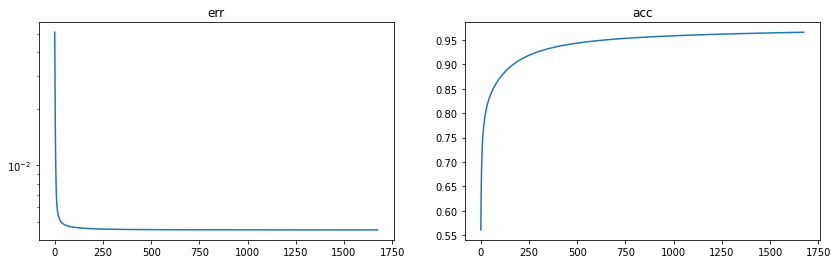

In [ ]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(result[1])
ax[0].set_title("err")
ax[1].plot(result[2])
ax[1].set_title("acc");

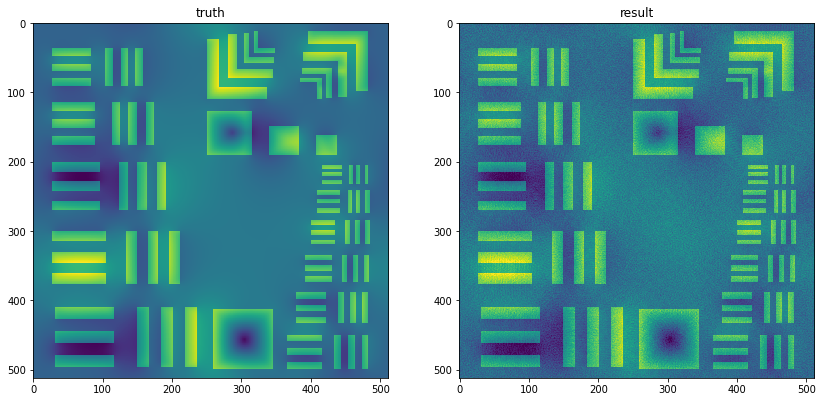

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

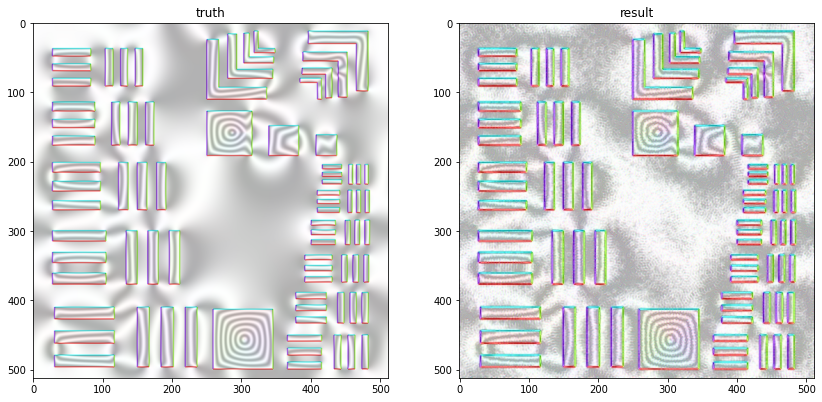

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),0,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

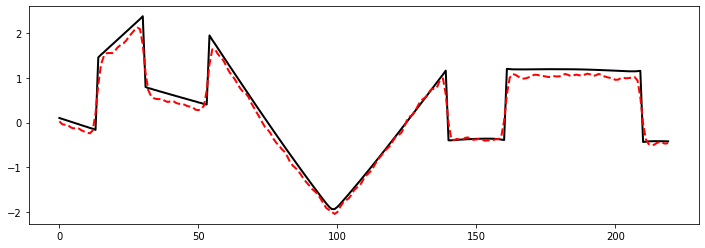

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)
ax.plot(t2[457,205:425], 'r--', linewidth=2)

# GS Phase Retrieval

In [ ]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 15

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

Downloading...
From: http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l
To: /content/amplitude4TIE_noise15.npy
136MB [00:01, 134MB/s]


In [ ]:
# generate microscopic transfer function

!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

from microscopes_fwd import Microscope

defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex128) # the part without the damping envelop
DampEnvs = np.zeros(A_samples.shape, dtype=np.float64)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  chiq = TEM.getChiQ(qq,del_px)
  tf_microscope[i] = np.cos(chiq) - 1j * np.sin(chiq)
  DampEnvs[i] =  TEM.getDampEnv(qq, del_px)

#A_samples /= A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 9.32MB/s]


In [ ]:
selection = [0,29,35,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]
DE = fftshift(DampEnvs[selection], axes=(1,2))

chosen defocus (mm):  [-1.6  -0.15  0.15  1.6 ]


In [ ]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False)
# guess_amplitude = np.copy(A_samples[32])  # for noise free data
# initialize the phase as 0.5 everywhere
guess_phase = np.zeros(A_samples[32].shape)+0.5

In [ ]:
ObjWave = guess_amplitude * np.exp(1j*guess_phase)

acc = []
err = []

maxiter = 10000
t1 = time.time()
tol = 1e-9

t1 = time.time()

for i in range(maxiter):

  ImgWave = ifft2(fft2(ObjWave)*TF*DE)
  err.append(((np.abs(ImgWave)/np.abs(ImgWave).mean(1).mean(1)[:,np.newaxis,np.newaxis]-exp_data)**2).mean())
  ImgWave = ImgWave / np.abs(ImgWave) * exp_data
  #          ------  back propagation  -------  weighted sum with DE as weight (only works for small defocus)
  ObjWave = ifft2( (fft2(ImgWave)*np.conj(TF)).sum(0) / DE.sum(0) )
  result_phase = np.angle(ObjWave)
  result_phase = unwrap_phase(result_phase)
  result_phase -= result_phase.mean()
  acc.append( (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum()) )
  if i>10:
    if np.abs(err[-1]-err[-2]) < tol or err[-1]>err[-2]:
      break
    if not i%100:
      print(err[-2]-err[-1], acc[-1])
  ObjWave = guess_amplitude * np.exp(1j*result_phase)

t2=time.time()
err = np.array(err)
acc = np.array(acc)

print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,i))
print("final err {0}".format(err[-1]))
print("final acc {0:.3f} ".format(acc[-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(acc.max(), acc.argmax()))

# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

3.382265612736357e-06 0.7972179738220375
8.158037595549367e-07 0.8361596829278635
3.667316655119393e-07 0.8565483448499837
1.9755201386209564e-07 0.8682230040841591
1.0942596602014215e-07 0.874638091664181
6.030750528129847e-08 0.877532537440303
2.7435721179289163e-08 0.8779325276358145
4.916620130121507e-09 0.8764758533297845
total elapsed time 212.1 s for 823 iterations: 
final err 0.006491149299797564
final acc 0.876 
max acc 0.878 at iteration #668: 


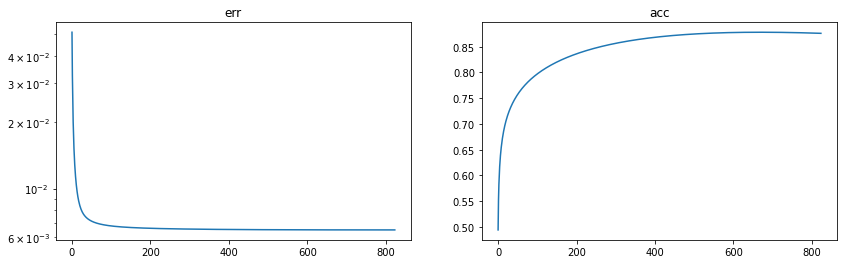

In [ ]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(err)
ax[0].set_title("err")
ax[1].plot(acc)
ax[1].set_title("acc");

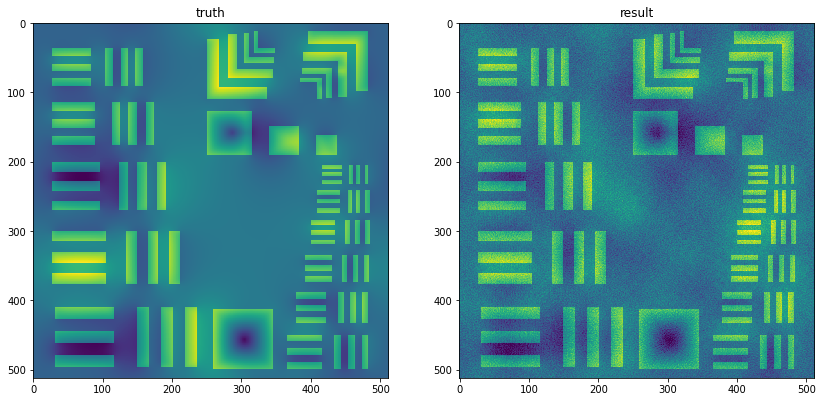

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

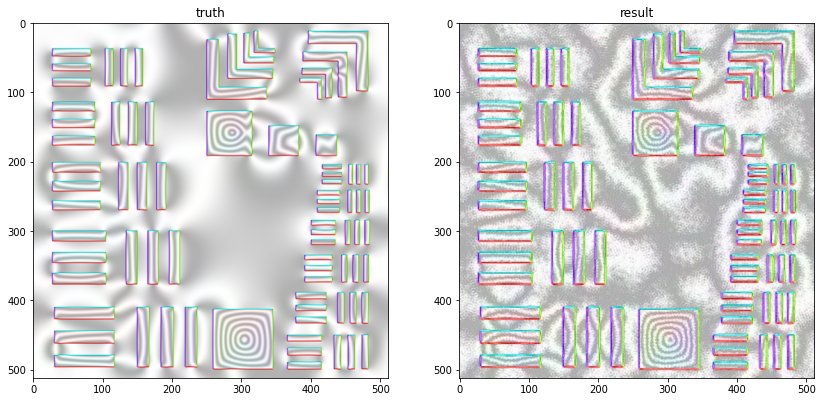

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),0,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

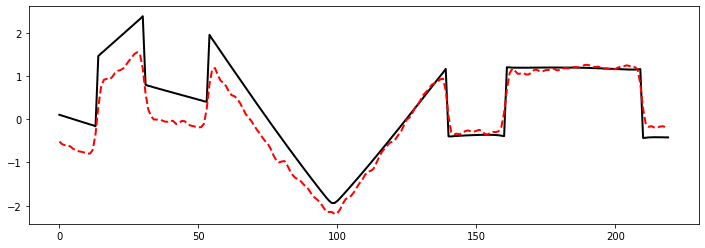

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)
ax.plot(t2[457,205:425], 'r--', linewidth=2)

# Partial Probe Retrieval with AD

In [ ]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 15

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l
To: /content/amplitude4TIE_noise15.npy
136MB [00:00, 158MB/s]
estimated noise from transparent region : 16.9%


In [ ]:
# rewriting the microscope transfer function with tensorflow

import scipy.constants as physcon

[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

del_px = 5 #nm/px

E = 200.0e3
Cs=1.0e6
Cc=5.0e6
Ca=0.0e6
phi_a=0
def_spr = 500

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0
spread = def_spr / del_px

scale1 = 250
scale2 = 100

def getTF(defoc, theta_c, defoc_offset):

  def_val = (defoc + defoc_offset * scale1) / del_px

  theta_c = tf.math.pow(10, theta_c/scale2)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5 
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3   
  p7 = def_val * lam  # a tensor
        
  u = 1.0 + p3 * qq**2 
  chiq = -p1 * qq**2 + p2 * qq**4  
  es_arg = 1.0/(2.0*u) * p4 * qq**4   
  et_arg = tf.math.multiply(1.0/u, tf.math.multiply(p5, (p6 * qq**3 - tf.math.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = tf.cast(tf.exp(es_arg-et_arg), tf.complex64)   # a tensor

  transfer_function = tfs.fftshift(tf.math.multiply(tf.complex(tf.cos(chiq),-tf.sin(chiq)), dampenv), axes=(1,2))

  return transfer_function

In [ ]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*getTF(defoc, theta_c, defoc_offset))

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2)

  gerr = losses
  return losses


In [ ]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []
  theta_cs = []
  defoc_offsets = []
  theta_cs.append(float(theta_c))
  defoc_offsets.append(float(defoc_offset))

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    if i>50:
      train = opt.minimize(compute_loss, var_list=[guess_phase, theta_c, defoc_offset])
    else:
      train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    theta_cs.append(float(theta_c))
    defoc_offsets.append(float(defoc_offset))
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    if i>10:
      if np.abs(errs[-1]-errs[-2]) < tol:
        break
      if not i%100:
        print(errs[-2]-errs[-1], accs[-1], np.power(10,float(theta_c)/scale2), float(defoc_offset)*scale1/1000.)

  return result_phase, np.array(errs), np.array(accs), i, np.array(defoc_offsets)*scale1/1000., np.power(10,np.array(theta_cs)/scale2)

In [ ]:
selection = [0,29,35,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = A_samples[selection]

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
#guess_amplitude = tf.constant(np.copy(A_samples[32]), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

defoc = tf.constant(defocus[selection][:, np.newaxis, np.newaxis]-1e4, dtype=tf.float32)
theta_c = tf.Variable(-400, dtype=tf.float32) #-500
defoc_offset = tf.Variable(0, dtype=tf.float32) #10

chosen defocus (mm):  [-1.6  -0.15  0.15  1.6 ]


In [ ]:
tot_errs = []
tot_accs = []

lr = 1
max_iter = 10000
t1=time.time()
result=optimize(1e-9,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

0.000751134 0.7652311162819612 3.205202019574225e-05 2.5750620365142822
1.8314458e-06 0.8807009535040327 1.0340720060394917e-05 8.814081192016602
4.954636e-07 0.9110753624227047 1.0343372619655528e-05 9.564135551452637
2.1839514e-07 0.9268836041440721 1.0349712447610522e-05 9.86508846282959
1.13621354e-07 0.9365273324021836 1.0351443488437422e-05 10.031590461730957
6.519258e-08 0.9429481011598253 1.0351232547805798e-05 10.135820388793945
4.0978193e-08 0.9474893297047924 1.0350999790718037e-05 10.20651626586914
2.561137e-08 0.9508647327664383 1.0351087074012605e-05 10.256468772888184
1.6763806e-08 0.9534907896961248 1.0351137989607667e-05 10.291897773742676
1.0244548e-08 0.9556133987889901 1.0350948875802754e-05 10.317309379577637
6.9849193e-09 0.9573761173666129 1.0350621571613016e-05 10.335710525512695
4.656613e-09 0.9588719142823372 1.0350301550856862e-05 10.349571228027344
2.7939677e-09 0.9601637613728051 1.0350003358603202e-05 10.360610008239746
1.3969839e-09 0.9612953410230259 1.0

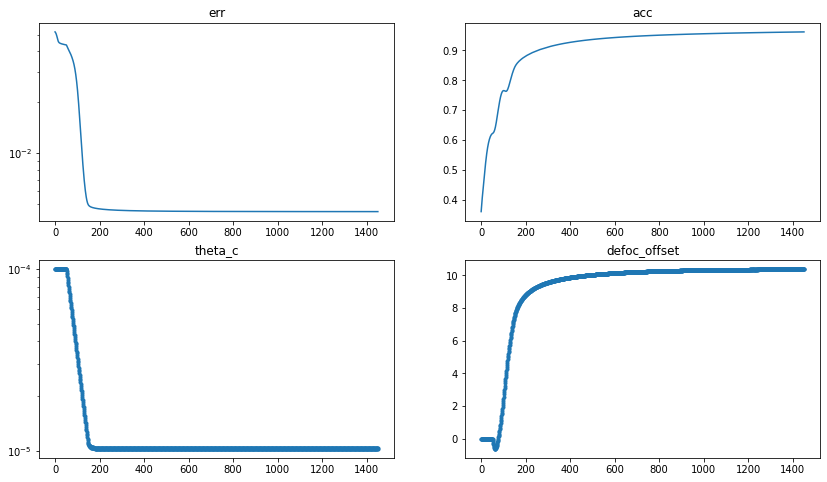

In [ ]:
f, ax = plt.subplots(ncols=2, nrows=2, figsize = (14,8))
ax[0,0].semilogy(result[1])
ax[0,0].set_title("err")
ax[0,1].plot(result[2])
ax[0,1].set_title("acc");
ax[1,0].semilogy(result[-1], '.')
ax[1,0].set_title("theta_c");
ax[1,1].plot(result[-2], '.')
ax[1,1].set_title("defoc_offset");

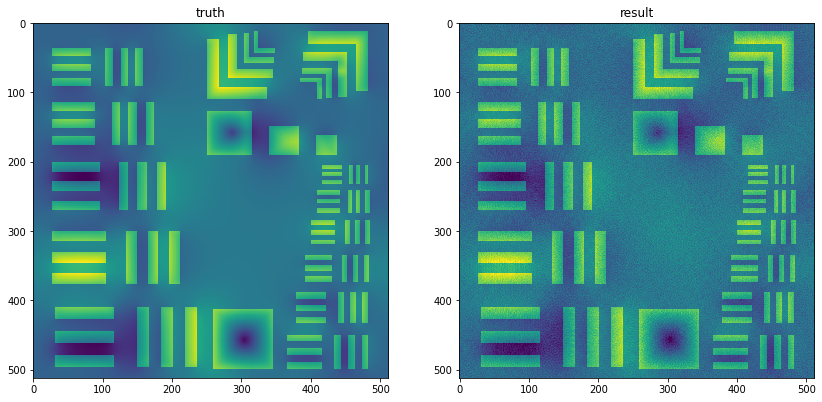

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

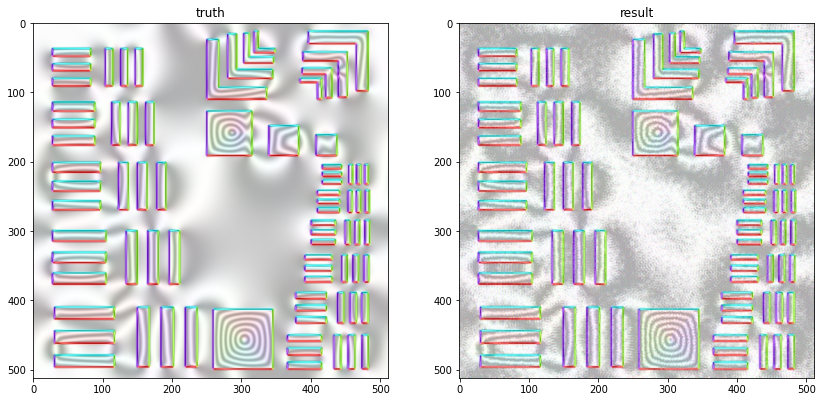

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),1,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

# Exp Data AD

In [6]:
!pip install fabio
import fabio
from scipy.signal import fftconvolve

     |████████████████████████████████| 3.4MB 28.8MB/s 


In [7]:
!gdown "http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54"
expdata = fabio.open("FS4_restest_q_10mu_1s_alimj_crp.tif")

Downloading...
From: http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54
To: /content/FS4_restest_q_10mu_1s_alimj_crp.tif
105MB [00:02, 41.6MB/s] 


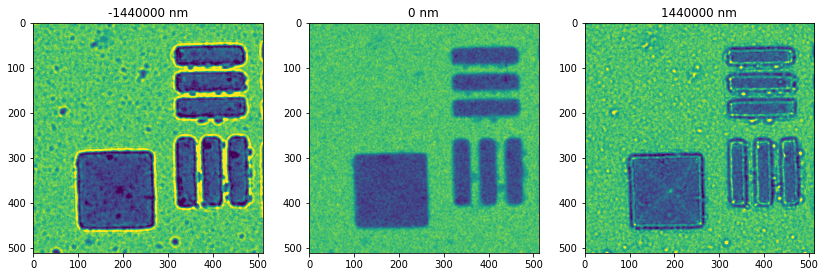

In [8]:
A_samples = np.zeros((25,512,512))

for i in range(25):
  A_samples[i] =  expdata.getframe(i).data[185-13:697-13,:512]

A_samples = np.sqrt(A_samples)
A_samples/=A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

defocus = np.array([-1440000,-1210000,-1000000,-810000,-640000,-490000,-360000,-250000,-160000,-90000,-40000,-10000,0,\
                      10000,40000,90000,160000,250000,360000,490000,640000,810000,1000000,1210000,1440000])

f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[12], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[1].set_title("{0} nm".format(defocus[12]))
ax[2].imshow(A_samples[24], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[2].set_title("{0} nm".format(defocus[24]));

In [9]:
# rewriting the microscope transfer function with tensorflow

import scipy.constants as physcon

[dim,dim] = A_samples[12].shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

del_px = 6.9 #nm/px

E = 200.0e3
Cs=1.0e6
Cc=5.0e6
Ca=0.0e6
phi_a=0
def_spr = 500

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0
spread = def_spr / del_px

scale1 = 1
scale2 = 100

def getTF(defoc, theta_c):

  def_val = defoc * scale1 / del_px

  theta_c = tf.math.pow(10, theta_c/scale2)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5 
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3   
  p7 = def_val * lam  # a tensor
        
  u = 1.0 + p3 * qq**2 
  chiq = -p1 * qq**2 + p2 * qq**4  
  es_arg = 1.0/(2.0*u) * p4 * qq**4   
  et_arg = tf.math.multiply(1.0/u, tf.math.multiply(p5, (p6 * qq**3 - tf.math.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = tf.cast(tf.exp(es_arg-et_arg), tf.complex64)   # a tensor

  transfer_function = tfs.fftshift(tf.math.multiply(tf.complex(tf.cos(chiq),-tf.sin(chiq)), dampenv), axes=(1,2))

  return transfer_function

In [10]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*getTF(defoc, theta_c))

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2) + lamb*tf.image.total_variation(tf.expand_dims(guess_phase,axis=-1))

  gerr = losses
  return losses


In [11]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  theta_cs = []
  defocs = []
  theta_cs.append(float(theta_c))

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    if i>50:
      train = opt.minimize(compute_loss, var_list=[guess_phase, theta_c])
    else:
      train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    theta_cs.append(float(theta_c))
    
    errs.append(gerr.numpy())
    if i>10:
      #if np.abs(errs[-1]-errs[-2]) < tol:
      #  break
      if not i%100:
        print(errs[-2]-errs[-1], np.power(10,float(theta_c)/scale2))

  result_phase = guess_phase.numpy()
  result_phase = unwrap_phase(result_phase)
  result_phase -= result_phase.mean()
  
  return result_phase, np.array(errs), i, np.power(10,np.array(theta_cs)/scale2)

In [ ]:
selection = [2,5,19,22]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = A_samples[selection]

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[12], weight=0.025, multichannel=False), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[12].shape)+0.5, dtype='float32') 

defoc = tf.constant(defocus[selection][:, np.newaxis, np.newaxis]/scale1, dtype=tf.float32)
theta_c = tf.Variable(-400, dtype=tf.float32) 

chosen defocus (mm):  [-1.   -0.49  0.49  1.  ]


In [ ]:
tot_errs = []
lr = 1
lamb = 0e-9
max_iter = 1000
# it takes about 50000-100000 iterations on the exp data
for iii in range(1): 
  t1=time.time()
  result=optimize(1e-9,max_iter=max_iter,lr=lr)
  t2=time.time()
  print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[2]))
  print("final err {0}".format(result[1][-1]))

# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

1.706183e-05 3.64628222853182e-05
2.5432091e-06 2.2604200349059038e-05
1.0038493e-06 2.2492022196090636e-05
5.3690746e-07 2.2205578769241068e-05
3.4371624e-07 2.186232519970698e-05
2.4371548e-07 2.1556436312136928e-05
1.8317951e-07 2.1298528990067325e-05
1.4388934e-07 2.1078693501910318e-05
1.169974e-07 2.0885460489574312e-05
total elapsed time 72.1 s for 999 iterations: 
final err 0.0008336794562637806


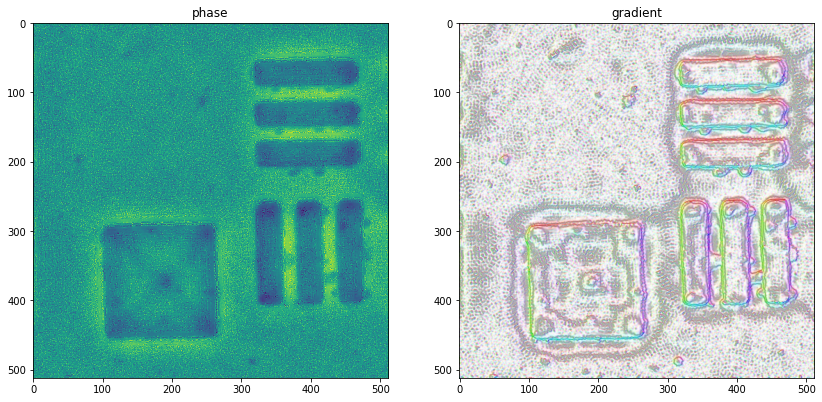

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

ax[0].imshow(result[0], interpolation='none', cmap='viridis')
ax[0].set_title("phase")

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap='gray', alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("gradient");

Downloading...
From: http://drive.google.com/uc?id=1zCFlGXpB6Mn5Wwlu_LUBKuCvdHe-18Hl
To: /content/exp_AD_2_5_19_22.npy
21.0MB [00:00, 79.6MB/s]


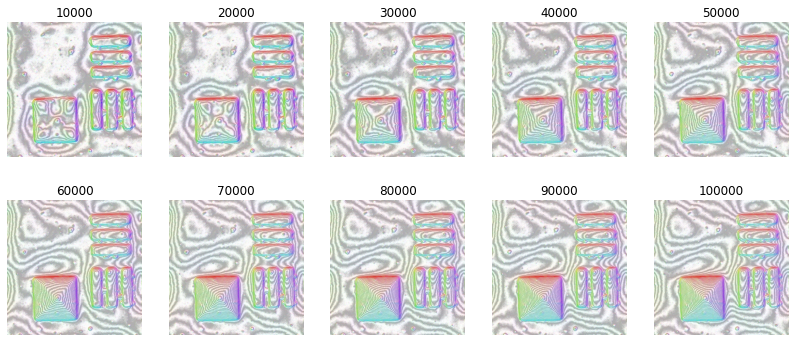

In [13]:
# because it might take time to run 100k iterations, this is the evolution of phase gradient every 10000 iterations
!gdown "http://drive.google.com/uc?id=1zCFlGXpB6Mn5Wwlu_LUBKuCvdHe-18Hl"

from microscopes_fwd import Plot_ColorMap

recon = np.load("exp_AD_2_5_19_22.npy")

f, ax = plt.subplots(nrows=2, ncols=5, figsize=(14,6))

for i in range(10):
  t2 = recon[i]
  gx=np.gradient(t2,axis=0)
  gy=np.gradient(t2,axis=1)
  rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
  ax[int(i/5),i%5].imshow(rgb_map)
  ax[int(i/5),i%5].imshow(np.cos(t2*10), cmap='gray', alpha=.3, vmin=-1, vmax=1)
  ax[int(i/5),i%5].set_axis_off()
  ax[int(i/5),i%5].set_title((i+1)*10000);

In [30]:
# concurrent optimization of amplitude and phase
# load check point phase, then do 10k iterations of phase only optimization + 10k of phase-amplitude co-optimization

checkpoint_phase = np.load("exp_AD_2_5_19_22.npy")[9]

In [31]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude/tf.reduce_mean(guess_amplitude)*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude/tf.reduce_mean(guess_amplitude)*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*getTF(defoc, theta_c))

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2) + lamb*tf.image.total_variation(tf.expand_dims(guess_amplitude,axis=-1))

  gerr = losses
  return losses


In [32]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  theta_cs = []
  defocs = []
  theta_cs.append(float(theta_c))

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    if i<10000:
      train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    else:
      train = opt.minimize(compute_loss, var_list=[guess_phase, guess_amplitude]) #Optim amplitude and phase
    errs.append(gerr.numpy())
    if i>10:
      if errs[-1]>errs[-10]:
        break
      if not i%1000:
        print(i, gerr.numpy())

  result_phase = guess_phase.numpy()
  result_phase = unwrap_phase(result_phase)
  result_phase -= result_phase.mean()
  result_amplitude = guess_amplitude.numpy()
  result_amplitude /= result_amplitude.mean()
  return result_phase, np.array(errs), i, result_amplitude

In [33]:
selection = [2,5,19,22]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = A_samples[selection]

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.Variable(denoise_tv_chambolle(A_samples[12], weight=0.025, multichannel=False), dtype='float32')
# 
guess_phase = tf.Variable(checkpoint_phase, dtype='float32') 

defoc = tf.constant(defocus[selection][:, np.newaxis, np.newaxis]/scale1, dtype=tf.float32)
theta_c = tf.constant(-470, dtype=tf.float32) 

chosen defocus (mm):  [-1.   -0.49  0.49  1.  ]


In [34]:
tot_errs = []
lr = 0.5
lamb = 1e-9
max_iter = 20000
for iii in range(1): 
  t1=time.time()
  result=optimize(1e-9,max_iter=max_iter,lr=lr)
  t2=time.time()
  print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[2]))
  print("final err {0}".format(result[1][-1]))

# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

1000 0.0007929351
2000 0.00075470976
3000 0.00074020255
4000 0.0007321719
5000 0.000726873
6000 0.00072301703
7000 0.0007200258
8000 0.00071759504
9000 0.00071555696
10000 0.00071380724
11000 0.00070959196
12000 0.00070804375
13000 0.00070677785
14000 0.00070566765
15000 0.00070466567
16000 0.0007037463
17000 0.0007028941
18000 0.00070209877
19000 0.0007013539
total elapsed time 1378.1 s for 19999 iterations: 
final err 0.000700657139532268


Text(0, 0.5, 'loss')

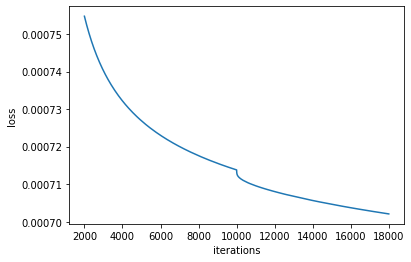

In [35]:
plt.plot(np.arange(2000,18000),result[1][2000:18000])
plt.xlabel("iterations")
plt.ylabel("loss")

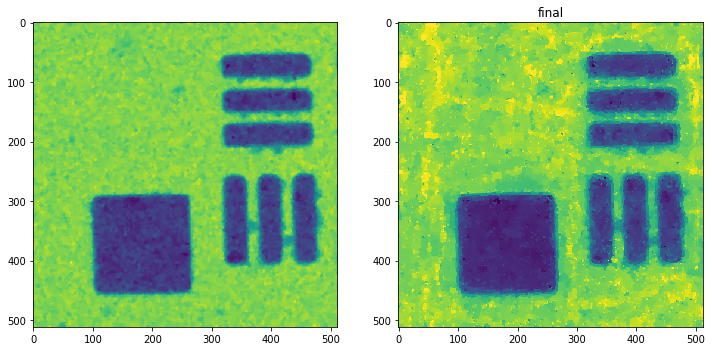

In [21]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (12,6))
amp_guess = denoise_tv_chambolle(A_samples[12], weight=0.025, multichannel=False)
amp_final = result[3]
amp_final /= amp_final.mean()
A_start = denoise_tv_chambolle(A_samples[12], weight=0.025, multichannel=False)
ax[0].imshow(amp_guess, interpolation='none', cmap='viridis', vmin=amp_guess.min(), vmax = amp_guess.max())
ax[1].set_title("guess");
ax[1].imshow(amp_final, interpolation='none', cmap='viridis', vmin=amp_guess.min(), vmax = amp_guess.max())
ax[1].set_title("final");

# Exp Data GS


In [ ]:
!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"

from microscopes_fwd import Microscope

defocus = np.array([-1440000,-1210000,-1000000,-810000,-640000,-490000,-360000,-250000,-160000,-90000,-40000,-10000,0,\
                      10000,40000,90000,160000,250000,360000,490000,640000,810000,1000000,1210000,1440000])

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500) 


#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 6.9 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex128)
DampEnvs = np.zeros(A_samples.shape, dtype=np.float64)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  chiq = TEM.getChiQ(qq,del_px)
  tf_microscope[i] = np.cos(chiq) - 1j * np.sin(chiq)
  # tf_microscope[i] = TEM.getTransferFunction(qq, del_px)
  DampEnvs[i] =  TEM.getDampEnv(qq, del_px)


Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 16.9MB/s]


In [ ]:
selection = [2,5,19,22]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]
DE = fftshift(DampEnvs[selection], axes=(1,2))

chosen defocus (mm):  [-1.   -0.49  0.49  1.  ]


In [ ]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = denoise_tv_chambolle(A_samples[12], weight=0.025, multichannel=False)
# initialize the phase as 0.5 everywhere
guess_phase = np.zeros(A_samples[12].shape)+0.5

In [ ]:
ObjWave = guess_amplitude * np.exp(1j*guess_phase)

err = []

maxiter = 1000
t1 = time.time()
tol = 1e-9

t1 = time.time()

for i in range(maxiter):

  ImgWave = ifft2(fft2(ObjWave)*TF*DE)
  err.append(((np.abs(ImgWave)/np.abs(ImgWave).mean(1).mean(1)[:,np.newaxis,np.newaxis]-exp_data)**2).mean())
  ImgWave = ImgWave / np.abs(ImgWave) * exp_data
  #          ------  back propagation  -------  weighted sum with DE as weight (only works for small defocus)
  ObjWave = ifft2( (fft2(ImgWave)*np.conj(TF)).sum(0) / DE.sum(0) )
  result_phase = np.angle(ObjWave)
  result_phase = unwrap_phase(result_phase)
  result_phase -= result_phase.mean()
  if i>10:
    if not i%100:
      print(err[-2]-err[-1])
  ObjWave = guess_amplitude * np.exp(1j*result_phase)

t2=time.time()
err = np.array(err)

print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,i))
print("final err {0}".format(err[-1]))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

1.2831064625331602e-06
5.964412695504736e-07
3.951088128420228e-07
2.8682091657208225e-07
2.1907592042433137e-07
1.763436628748026e-07
1.4340031236482857e-07
1.193124583953424e-07
1.0108466681367154e-07
total elapsed time 262.7 s for 999 iterations: 
final err 0.0013570611889351942


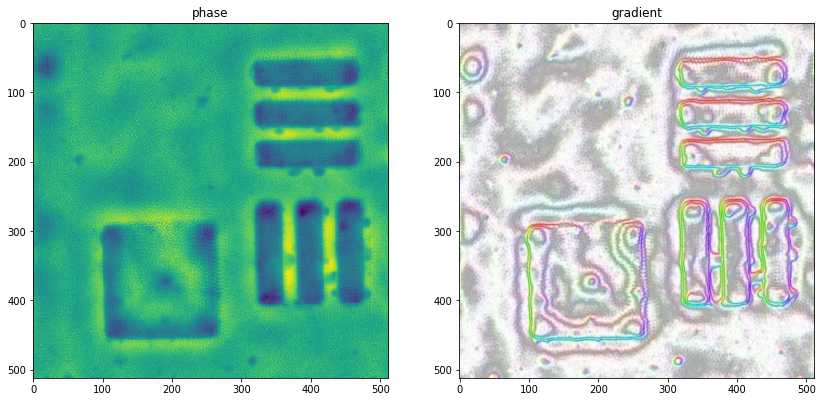

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

ax[0].imshow(result_phase, interpolation='none', cmap='viridis')
ax[0].set_title("phase")

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap='gray', alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("gradient");